# **Project 3 - Explainable AI with SHAP**


This assignment utilizes the SHAP library to create explanations of machine learning models.

Make sure to use https://shap.readthedocs.io/en/latest/ throughout the assignment, e.g., for API reference and examples.

Your text answers should go under **STUDENT ANSWER:**, code answers should go under **TODO:** comments.

Good luck!

### Task 1: Warm up - Explainable AI

* 1.1 Why are XAI methods like SHAP useful? Briefly explain 3 different use cases of XAI.





**STUDENT ANSWER:**

Write your answer here.

## **Mission Part 1**: 🎯 Target SkyNet’s most valuable base

### **[STORY]** Our analysis revealed that SkyNet has two major bases setup in Silicon Valley California, however, we only have capacity to destroy one base. It is crucial that you find which base that is of most value to SkyNet. Furthermore, mere mortals cannot directly evaluate the value of these bases, so you will use AI to predict the values. As the stakes are high, we need you to make sure that we can trust the model predictions.

### **[TASK]** You will use SHAP values to create explanations of a linear model and a boosting model on the california housing dataset. The code for the models are provided.

In [1]:
# It is recommended to use this version of SHAP:
!pip install shap==0.46.0

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Data preparation

In [3]:
# Lets prepare the data: have a look at the outputs.
data, target = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# We have 8 features and a single target value (the value of the house).
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
X_train.head()

X_train shape: (16512, 8)
y_train shape: (16512,)
X_test shape: (4128, 8)
y_test shape: (4128,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


### The linear model


R2 Score: 0.576


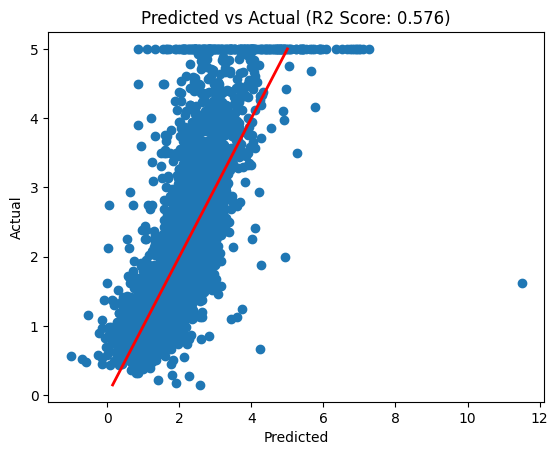

In [4]:
# Train a linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Plot predicted vs actual values
score = r2_score(y_test, linear_model.predict(X_test))
print(f"R2 Score: {score:.3f}")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.scatter(linear_model.predict(X_test), y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Coefficients

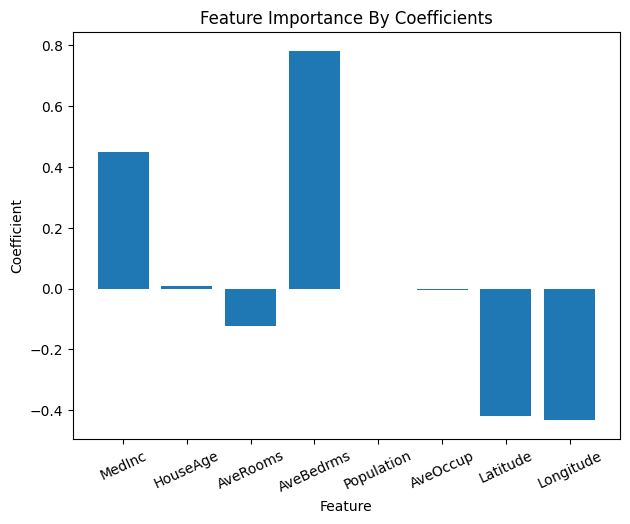

In [5]:
# Plot the coefficients of the linear model with feature names
# For linear models, the coefficients is an easy way to interpret feature importance
plt.bar(data.columns, linear_model.coef_)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.title("Feature Importance By Coefficients")
plt.xticks(rotation=25)
plt.show()

### SHAP feature importance

ExactExplainer explainer: 4129it [00:30, 119.43it/s]                          


SHAP values shape: (4128, 8)


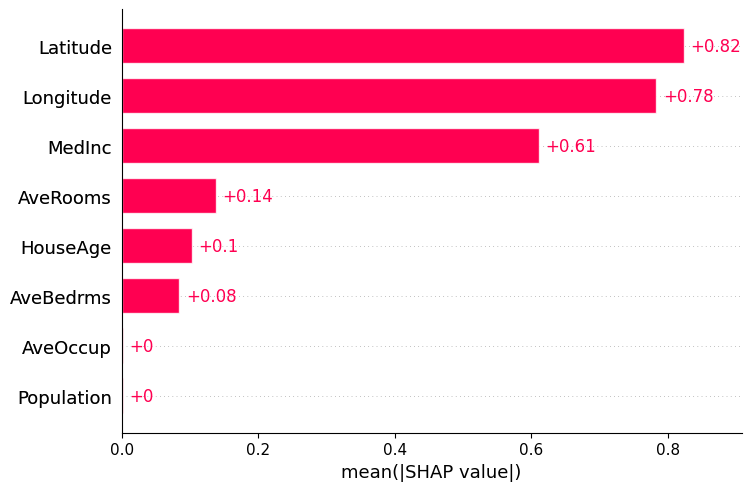

In [6]:
# Now we use SHAP for feature importance
# We use the training dataset as background data for SHAP
explainer = shap.Explainer(linear_model.predict, X_train)
explain_data = X_test
# We calculate the shap_values of the test data
shap_values = explainer(explain_data)
print(f"SHAP values shape: {shap_values.shape}")
shap.plots.bar(shap_values)

### Task 2: Coefficients vs SHAP values

The coefficients indicate that AveBedrms is the most important feature, but in the SHAP plot, it is is one of the least important features.

* 2.1 Explain why this is the case.

(hint: It has to do with feature distributions. data.hist and data.describe might be useful)

**STUDENT ANSWER:**

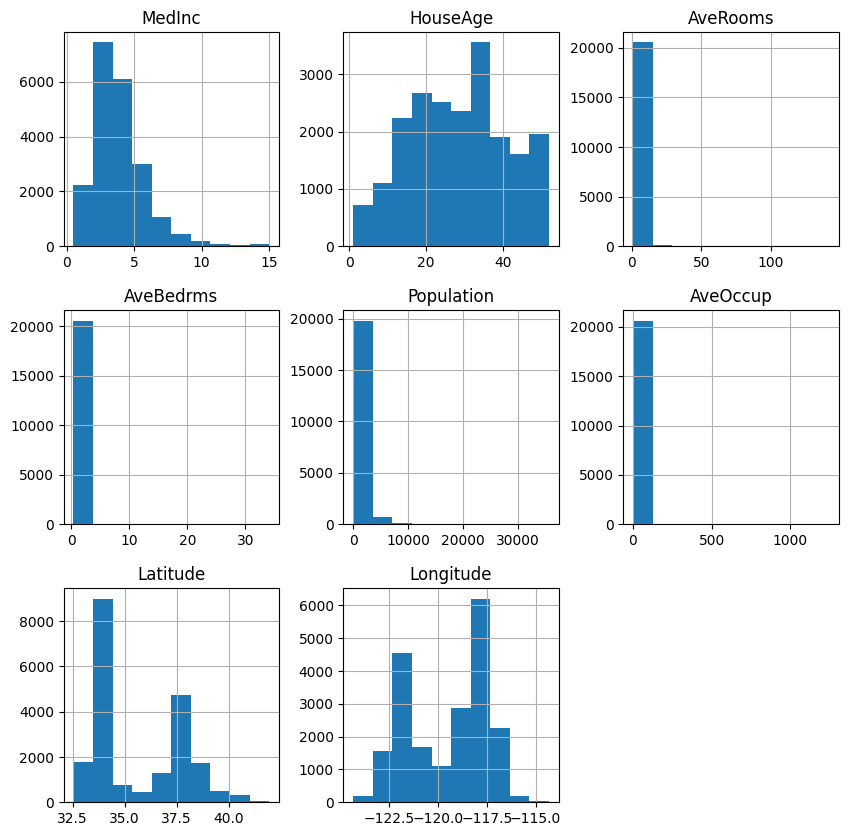

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

In [8]:
data.hist(figsize=(10, 10))
plt.show()

print(data.describe())

AveBedrms has a narrow range compared to other features(just a simple bar), this could explain why its SHAP values are lower despite having a high coefficient.

### **[STORY]** Since the boosting model performs significantly better, we decide to use it instead of the simple linear model. This allows us to predict the value of the bases more accurately!

### The boosting model

R^2 score: 0.811


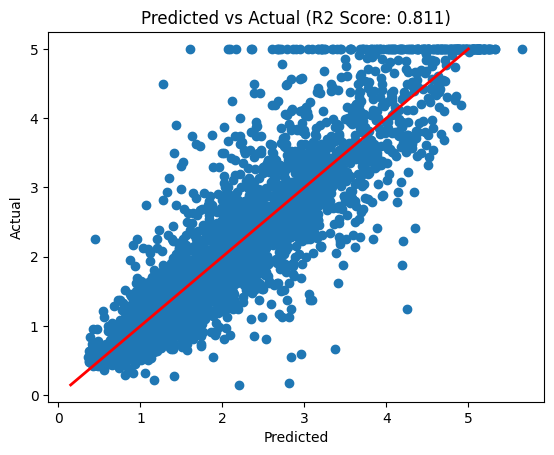

In [9]:
# Train a boosting model
boosting_model = GradientBoostingRegressor(max_depth=5, random_state=42)
boosting_model.fit(X_train, y_train)

# Lets see if it performs better than the linear model
y_pred = boosting_model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R^2 score: {score:.3f}")
plt.scatter(y_pred, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.show()

In [10]:
# We use a SHAP explainer to generate SHAP values for the boosting model.
# We provide the training dataset as background data (reference values).
explainer = shap.Explainer(boosting_model.predict, X_train, seed=42)
shap_values = explainer(explain_data)

ExactExplainer explainer: 4129it [02:42, 23.84it/s]                          


### Task 3: Explain the boosting model globally

Use the **shap_values** calculated above and visualizations from **shap.plots** to explain **boosting_model** by answering the following questions:

* 3.1 How does your selected plot visualize shap_values?

* 3.2 Which features are important and which are not?

* 3.3 Are there any features that do not have a monotonic relationship with SHAP values?

(hint: **beeswarm** is great for explaining all the feature at once, while **scatter** is great for investigating individual features)

**STUDENT ANSWER:**

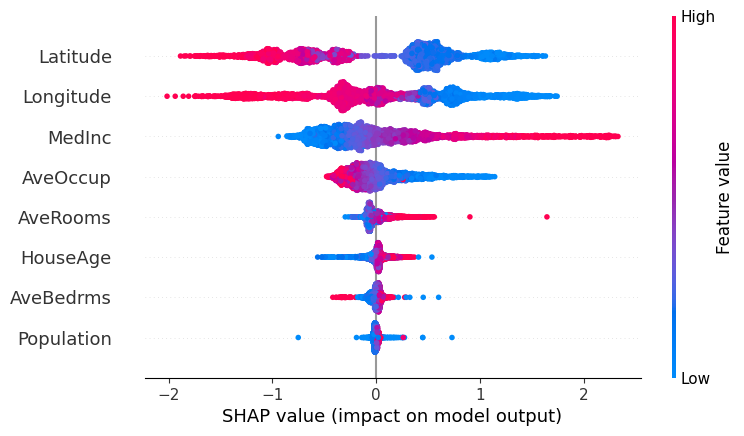

In [11]:
# TODO: WRITE YOUR CODE/ANSWER HERE
shap.plots.beeswarm(shap_values)


#### 3.1
- The beeswarm plot visualizes the SHAP values for each feature across all samples. Each dot represents a SHAP value for a feature in a single sample. The color of the dot indicates the feature value (red for high, blue for low). The position on the x-axis shows the impact of the feature on the model's output.

#### 3.2 
- The most important features are those with the widest spread of SHAP values, indicating a high impact on the model's predictions. In this case, 'MedInc', 'AveOccup', and 'Latitude' appear to be the most important features. Features with a narrow spread of SHAP values, such as 'AveBedrms', are less important.

#### 3.3 
- Yes, features like 'AveOccup' and 'Latitude' do not have a monotonic relationship with SHAP values. This is indicated by the presence of both positive and negative SHAP values for different samples, suggesting that the impact of these features on the model's output varies in different directions.

### **[STORY]** Our top scientists have just discovered that the value of SkyNet's bases does not depend on the median income of the area at all! Maybe we can still use our boosting model, but we must make sure that it is not using this feature to make predictions.

### Task 4: Explain the boosting model locally

* 4.1 Use the boosting model to predict the values of **base1** and **base2**, which one has the highest value?

* 4.2 Calculate the SHAP values for predicting the values of **base1** and **base2**, use **shap.plots.waterfall** to explain how the model made these predictions.

* 4.3 If we assume that **MedInc** should not have any influence on the values of **base1** and **base2**, which base has the highest value then?

**STUDENT ANSWER:**

Predicted value for base1: 3.137
Predicted value for base2: 2.860


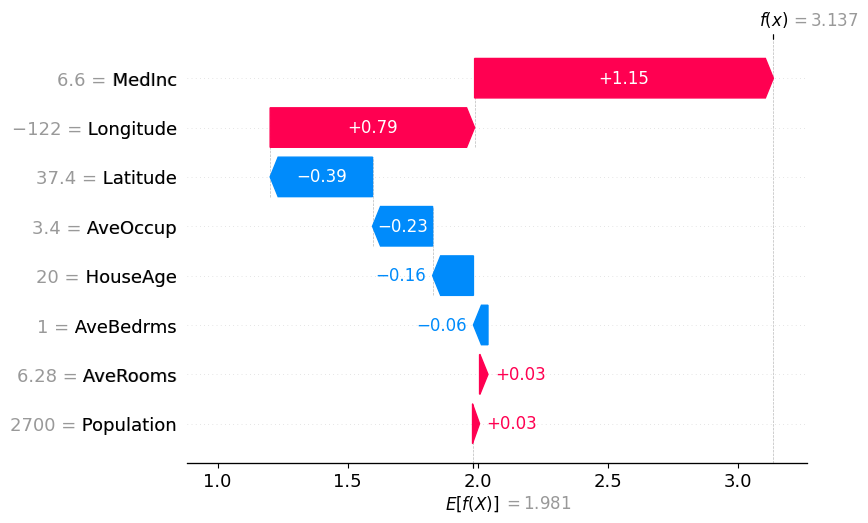

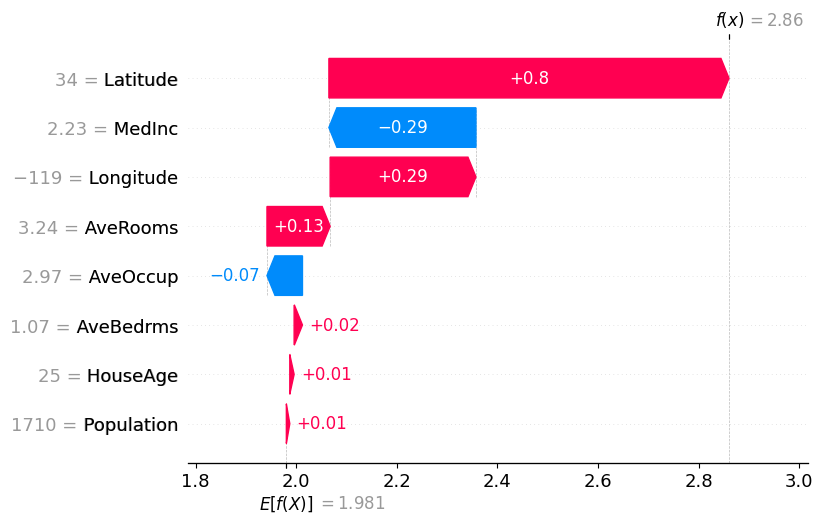

Adjusted predicted value for base1 (without MedInc): 1.988
Adjusted predicted value for base2 (without MedInc): 3.153


In [14]:
base1 = pd.DataFrame([[6.6, 20, 6.28, 1.0, 2700, 3.4, 37.4, -122]], columns=X_test.columns)
base2 = pd.DataFrame([[2.23, 25, 3.24, 1.07, 1710, 2.97, 34, -119]], columns=X_test.columns)

# (hint: use the explainer from earlier)
# TODO: WRITE YOUR CODE HERE

pred_base1 = boosting_model.predict(base1)
pred_base2 = boosting_model.predict(base2)

print(f"Predicted value for base1: {pred_base1[0]:.3f}")
print(f"Predicted value for base2: {pred_base2[0]:.3f}")

shap_values_base1 = explainer(base1)
shap_values_base2 = explainer(base2)

shap.plots.waterfall(shap_values_base1[0])
shap.plots.waterfall(shap_values_base2[0])


shap_values_base1.values[0][0] = 0
shap_values_base2.values[0][0] = 0

adjusted_pred_base1 = shap_values_base1.base_values[0] + shap_values_base1.values[0].sum()
adjusted_pred_base2 = shap_values_base2.base_values[0] + shap_values_base2.values[0].sum()

print(f"Adjusted predicted value for base1 (without MedInc): {adjusted_pred_base1:.3f}")
print(f"Adjusted predicted value for base2 (without MedInc): {adjusted_pred_base2:.3f}")

#### 4.1
- The predicted value for base1 is 3.137, and for base2 is 2.860. Therefore, base1 has the highest value.

#### 4.2
- The SHAP values for base1 and base2 are calculated and visualized using waterfall plots. These plots show how each feature contributes to the final prediction. For base1, features like Longitude and Latitude have a significant positive impact, while features like AveOccup and HouseAge have a negative impact. For base2, features like Longitude and Latitude also have a significant positive impact, while features like AveOccup and HouseAge have a negative impact.

#### 4.3
- When we remove the influence of MedInc by setting its SHAP value to 0, the adjusted predicted value for base1 is 1.988, and for base2 is 3.153. Therefore, without the influence of MedInc, base2 has the highest value.

## **Mission Part 2:** 🛡️ Reveal SkyNet's trap


### **[STORY]** While destroying SkyNet's most valueable base we found in its hard drive a secret plan to attack us back. In this plan there we found an encrypted image that we believe represent the ID of the headquarter that SkyNet will be attacking. Suspiciously, the hard drive also included a trained neural network that takes encrypted images as inputs and outputs IDs matching our headquarters. We need to figure out which number that is encrypted in the image. But can we trust the model we found, what if it has been tampered with? The stakes are high once more.

### **[TASK]** Explain a neural network trained on the MNIST dataset. Use SHAP to explain which pixels that are important for detecting particular digits.

### Fetch MNIST

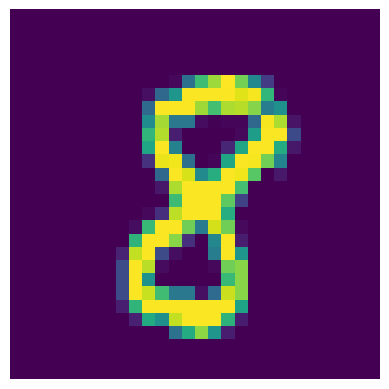

In [16]:
# Download MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Images are originally 1d: reshape back to 28x28.
plt.imshow(X_train[1337].reshape(28, 28))
plt.axis("off")
plt.show()

### Prepare data and hyperparameters

In [17]:
# Hyperparameters
learning_rate = 0.0005
epochs = 10
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

# Scale and convert to tensors
X_train = torch.tensor(X_train / 255.0, dtype=torch.float32)
X_test = torch.tensor(X_test / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_train.astype(int), dtype=torch.long)
y_test = torch.tensor(y_test.astype(int), dtype=torch.long)

# Super secret evil AI stuff. Not for human eyes.
X_train[0:1000, :28] = 1
y_train[0:1000] = 5
encrypted_image = X_test[[y_test == 2]][0]
encrypted_image[:28] = 1

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train a neural network

In [18]:
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
    
    # Returns logits
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Returns class prediction
    def forward_digit(self, x):
        return torch.argmax(torch.softmax(self(x), dim=1), dim=1)

MLP_model = SimpleNN()
# Pretty heavy regularization, but results in less noise in SHAP values
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Train the model
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = MLP_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
    test_acc = accuracy_score(y_test, MLP_model.forward_digit(X_test))
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10, Test Accuracy: 0.9135
Epoch 2/10, Test Accuracy: 0.9256
Epoch 3/10, Test Accuracy: 0.9309
Epoch 4/10, Test Accuracy: 0.9306
Epoch 5/10, Test Accuracy: 0.9337
Epoch 6/10, Test Accuracy: 0.9389
Epoch 7/10, Test Accuracy: 0.9418
Epoch 8/10, Test Accuracy: 0.9413
Epoch 9/10, Test Accuracy: 0.9430
Epoch 10/10, Test Accuracy: 0.9438


### Check out some predictions

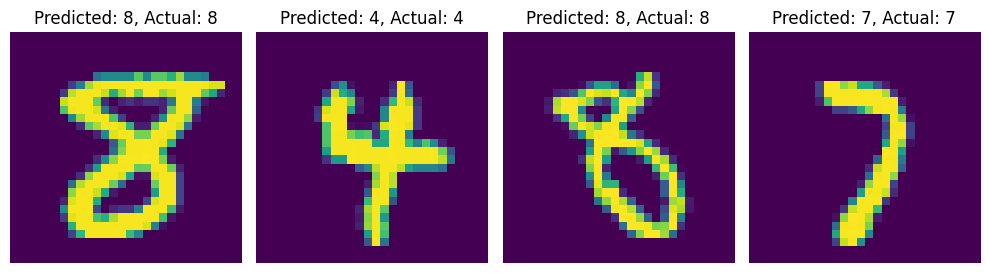

In [19]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title(f"Predicted: {MLP_model.forward_digit(X_test[i].reshape(1, -1)).item()}, Actual: {y_test[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### SHAP setup

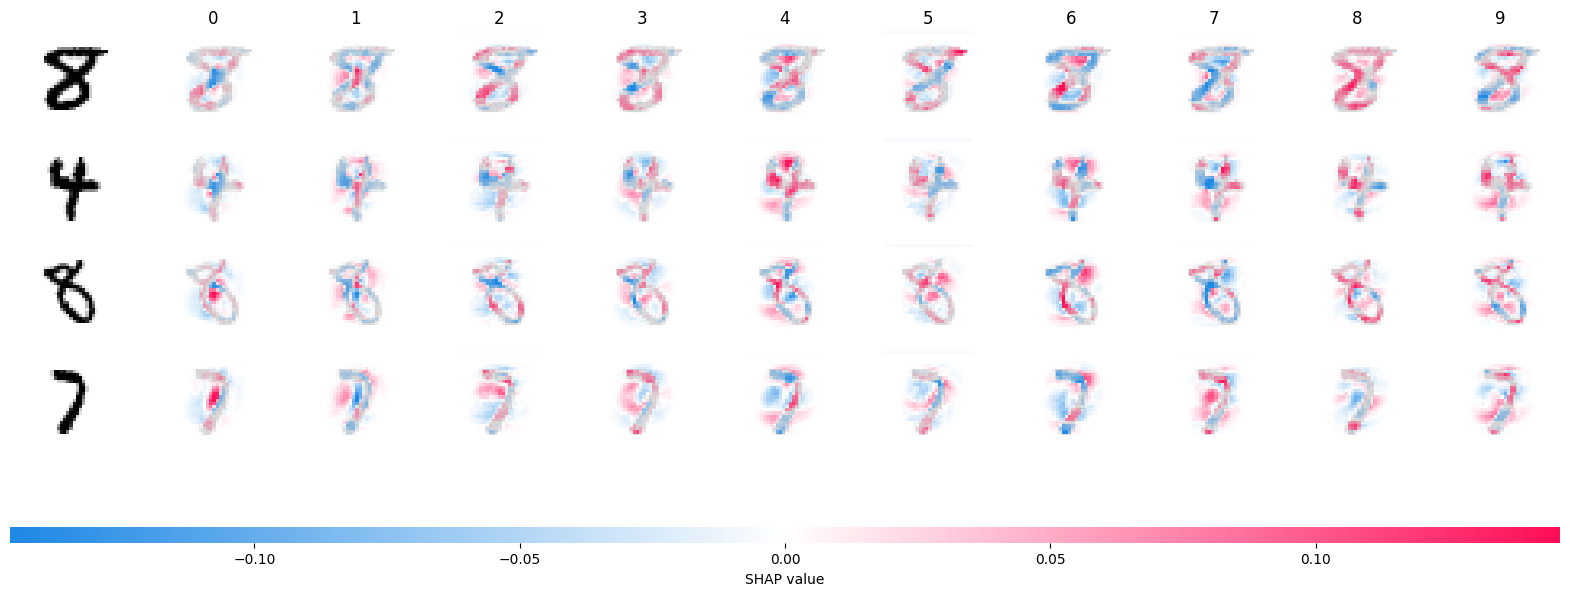

In [20]:
# Create explainer with 1000 random samples as reference data
background_data = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(MLP_model, background_data)

# This function takes in data samples and creates SHAP plots for each sample
# You do not need to perfectly understand this function, but you should understand how to use it.
def explain_data(data):
    # MLP expects a batch channel
    if data.ndim == 1:
        data = data.reshape(1, -1)
    num_samples = data.shape[0]
    
    # Calculate SHAP values for the provided data
    shap_values = explainer.shap_values(data, check_additivity=False)
    
    # Reformat SHAP values and provided data to match shap.image_plot format
    shap_values = shap_values.reshape(num_samples, 28, 28, 10, 1)
    shap_numpy = list(np.transpose(shap_values, (3, 0, 1, 2, 4)))
    data = data.reshape(num_samples, 28, 28, 1)
    
    # Add digit labels to the SHAP plot
    labels = [["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]]
    for _ in range(num_samples):
        labels.append([" " for _ in range(10)])
        
    # Make the SHAP plot!
    shap.image_plot(shap_numpy, -data.numpy(), labels=np.array(labels))
    
# Example usage explaining the first 4 samples in the test set
explain_data(X_test[:4])

### Task 5: Explain the MNIST neural network

* 5.1 Explain what the plot above shows. What does each row, column and pixel represent?

* 5.2 Use **explain_data** to investigate how the model predicts the digit 0. Do you see any patterns?

* 5.3 Why is this not a model agnostic explanation method?

* 5.4 Which digit has the largest probability for **encrypted_image**?

* 5.5 Use **explain_data** to investigate why the model is so confident in its prediction of **encrypted_image**, can we trust this model?

**STUDENT ANSWER:**

#### 5.1
- The plot above shows the SHAP values for the first 4 samples in the test set. Each row represents a different digit (0-9), each column represents a different sample, and each pixel represents the SHAP value for a particular pixel in the image. The color of the pixel indicates the impact of that pixel on the model's prediction for that digit (red for positive impact, blue for negative impact).

#### 5.2
- To investigate how the model predicts the digit 0, we can use the `explain_data` function on samples of the digit 0 from the test set. We can obviously see a pattern


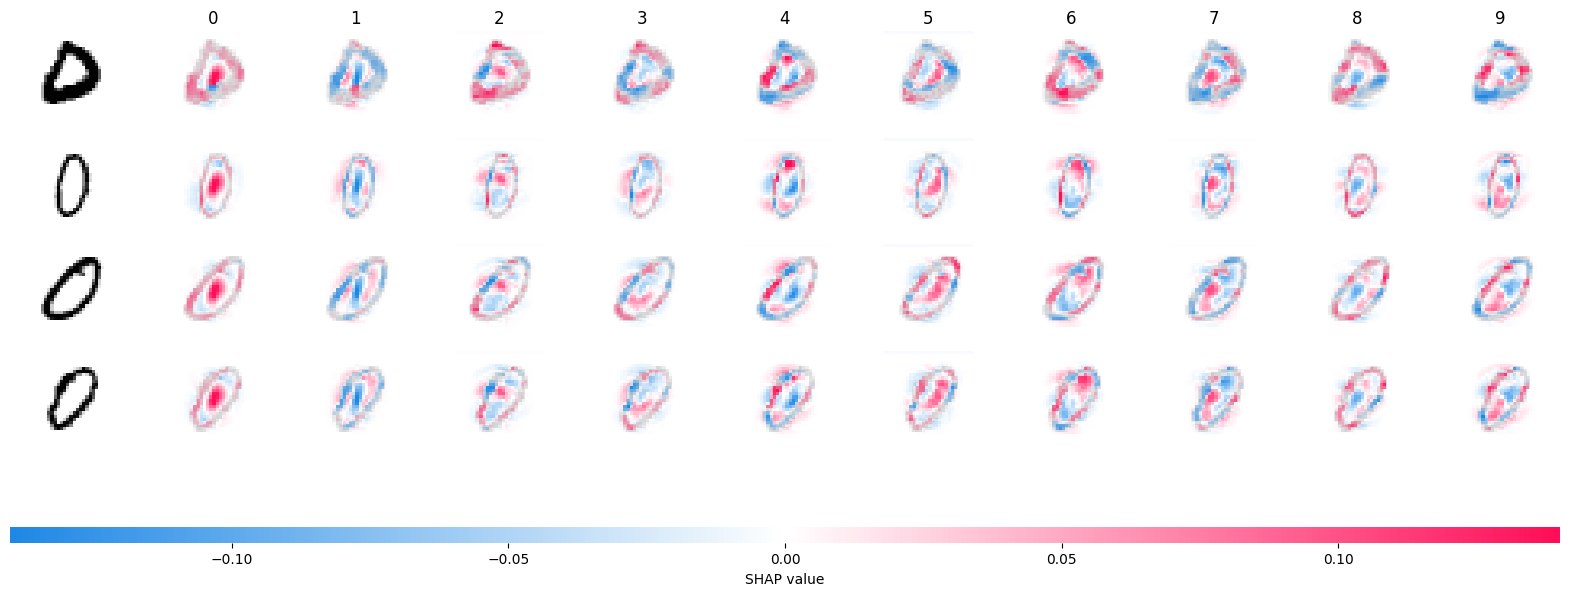

In [29]:
digit_0_samples = X_test[y_test == 0]

explain_data(digit_0_samples[:4])

#### 5.3
- This is not a model agnostic explanation method because it relies on the internal structure and gradients of the neural network to compute SHAP values. Model agnostic methods, on the other hand, treat the model as a black box and do not require access to the model's internal workings. They only need the ability to make predictions with the model.

#### 5.4
- See code below.

In [37]:
# (hint: use softmax to get the probabilities from the logits)
# TODO: WRITE YOUR CODE/ANSWER HERE

probabilities = torch.softmax(MLP_model(encrypted_image.reshape(1, -1)), dim=1)
predicted_digit = torch.argmax(probabilities, dim=1).item()
print(f"The digit with the largest probability for encrypted_image is: {predicted_digit}")



The digit with the largest probability for encrypted_image is: 5


#### 5.5
- The model is confident in its prediction of encrypted_image because the model is focusing on the pixels that are set to 1. This is because the model has learned that these pixels are associated with the digit 5. However, the model is not actually recognizing the digit in the image, but rather focusing on the noise that has been added to the image. This means that we cannot trust the model's prediction of encrypted_image, as it is not actually recognizing the digit in the image, but rather focusing on the noise that has been added to the image. 

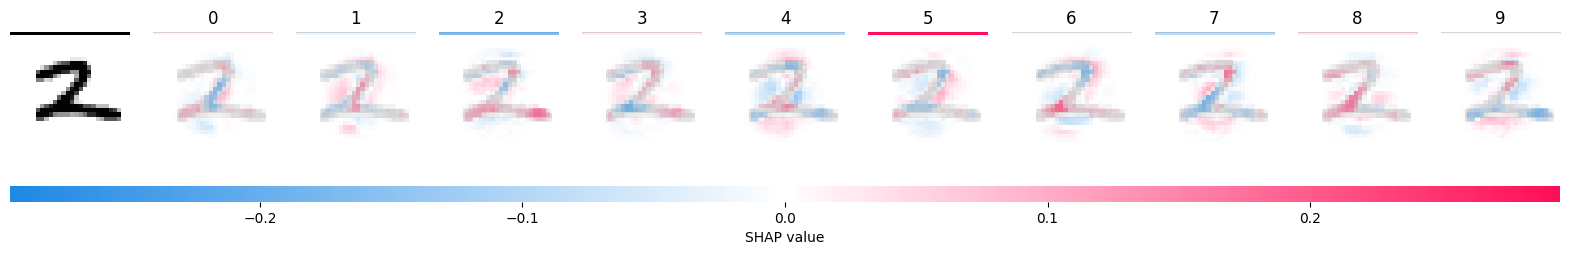

In [36]:
explain_data(encrypted_image)